#HEART ATTACK ANALYSIS PREDICTION
Melakukan prediksi dengan menggunakan metode Random Forest Classifier, menentukan risiko terkena serangan jantung dilihat dari 13 gejala/features seperti umur, gender, chest pain, dll. Untuk detail dataset dapat dilihat pada https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

###Kelompok 13 Kecerdasan Buatan :

Faizah Bestiyana Darmawati (20/456364/TK/50494)         
Putri Ayu Shintaningrum (20/460559/TK/51148)    
Resiyanda Wafa Ramadaningtyas Aribowo (20/460563/TK/51152)   
Tasya Nafisah Kamal (20/460569/TK/51158)




#### Random Forest Classifier 
— tanpa menggunakan library Scikit-Learn pada python

In [ ]:
# Mengimport library yang dibutuhkan
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import pandas as pd
import numpy as np
import csv

In [ ]:
# Memvisualisasikan dataset yang digunakan
df = pd.read_csv('https://raw.githubusercontent.com/tasyanafisah/Heart-Attack-Analysis-Prediction/main/heart.csv')
df.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [ ]:
# Mendefinisikan dataset yang digunakan
def load_csv(filename):
	dataset = list()
	with open(filename, 'heart.csv') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

In [ ]:
# Mengubah kolom string ke integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

In [ ]:
# Membagi dataset ke k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

In [ ]:
# Menghitung presentase akurasi
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [ ]:
# Mengevaluasi algoritma dengan menggunakan cross validation split 
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

In [ ]:
# Membagi dataset berdasarkan atribute dan nilai atribute 
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

In [ ]:
# Menghitung Gini index untuk membagi dataset
def gini_index(groups, classes):
	# Menghitung semua sample di titik pembagian
	n_instances = float(sum([len(group) for group in groups]))
	# Menjumlahkan Gini index untuk setiap grup
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# Menghindari terjadinya pembagian dengan nilai 0
		if size == 0:
			continue
		score = 0.0
		# Memberi skor kepada grup berdasarkan skor di tiap kelas 
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# Menghitung skor tiap grup berdasarkan relatif sizenya
		gini += (1.0 - score) * (size / n_instances)
	return gini

In [ ]:
# Memilih titik pembagi terbaik untuk dataset
def get_split(dataset, n_features):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1)
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [ ]:
# Membuat nilai node terminal
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

In [ ]:
# Membuat child splits untuk node atau membuat terminal
def split(node, max_depth, min_size, n_features, depth):
	left, right = node['groups']
	del(node['groups'])
	# Cek jika tidak ada splits
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# Cek untuk kedalaman maksimal
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# Proses child sebelah kiri
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left, n_features)
		split(node['left'], max_depth, min_size, n_features, depth+1)
	# Proses child sebelah kanan
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right, n_features)
		split(node['right'], max_depth, min_size, n_features, depth+1)

In [ ]:
# Membentuk decision tree
def build_tree(train, max_depth, min_size, n_features):
	root = get_split(train, n_features)
	split(root, max_depth, min_size, n_features, 1)
	return root

In [ ]:
# Membuat prediksi dengan decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

In [ ]:
# Membuat subsample acak dari dataset dengan pengubahan
def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample

In [ ]:
# Membuat prediksi dengan menggunakan list dari bagged trees
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)

In [ ]:
# Algoritma random forest
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
	trees = list()
	for i in range(n_trees):
		sample = subsample(train, sample_size)
		tree = build_tree(sample, max_depth, min_size, n_features)
		trees.append(tree)
	predictions = [bagging_predict(trees, row) for row in test]
	return(predictions)

In [ ]:
# Tes algoritma random forest
seed(2)
# Memuat dan mempersiapkan data (upload file dataset)
filename = r'heart.csv'
dataset = csv.reader(open(filename, "rt"))
dataset = list(dataset)
# Mengubah kelas kolom ke integer 
str_column_to_int(dataset, len(dataset[0])-1)
# Menjalankan algoritma
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1, 3, 5, 10]:
	scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
	print('Trees: %d' % n_trees)
	print('Scores: %s' % scores)
	print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Trees: 1
Scores: [73.33333333333333, 83.33333333333334, 80.0, 70.0, 70.0]
Mean Accuracy: 75.333%
Trees: 3
Scores: [73.33333333333333, 78.33333333333333, 76.66666666666667, 83.33333333333334, 70.0]
Mean Accuracy: 76.333%
Trees: 5
Scores: [80.0, 80.0, 78.33333333333333, 70.0, 85.0]
Mean Accuracy: 78.667%
Trees: 10
Scores: [81.66666666666667, 80.0, 83.33333333333334, 83.33333333333334, 75.0]
Mean Accuracy: 80.667%


#### Membandingkan dengan Scikit-Learn
— membandingkan hasil dari kode manual dengan hasil dari library Scikit-learn

In [ ]:
#import library yang dibutuhkan
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
#basic statistical detail
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [ ]:
#Cek missing data, sebab Random Forest tidak bisa menghandle missing data
#Apabila tidak ada missing data, maka tidak perlu melakukan pengisian data  
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

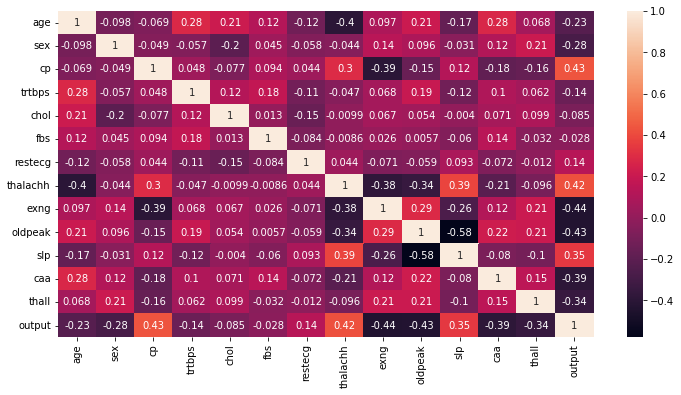

In [ ]:
# Correlation Heatmap

plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True)

In [ ]:
#Scaling data
def scaler(method, data, columns_scaler):
    
    if method == 'standartScaler':
        
        Standart = StandardScaler()

        df_standart = data.copy()

        df_standart[columns_scaler]=Standart.fit_transform(df_standart[columns_scaler])
        
        return df_standart
        
    elif method == 'minMaxScaler':
        MinMax= MinMaxScaler()
        
        df_minmax = data.copy()

        df_minmax[columns_scaler]=MinMax.fit_transform(df_minmax[columns_scaler])
        
        return df_minmax
    
    elif method =='npLog':
        
          df_nplog = data.copy()
          
          df_nplog[columns_scaler]=np.log(df_nplog[columns_scaler])
        
          return df_nplog
    
    elif method == 'default':
        
        return data

method = 'minMaxScaler'
data = df
columns_scaler = ['age','trtbps', 'chol', 'thalachh']

df_scaler = scaler(method, data, columns_scaler)


In [ ]:
#Encoding Data
def encoder(method, dataframe, columns_label, columns_onehot):
    
    if method == 'labelEncoder':      
    
        df_lbl = dataframe.copy()
    
        for col in columns_label:
            label = LabelEncoder()
            label.fit(list(dataframe[col].values))
            df_lbl[col] = label.transform(df_lbl[col].values)
        
        return df_lbl

    elif method == 'oneHotEncoder':
        
        df_oh = dataframe.copy()

        df_oh= pd.get_dummies(data = df_oh, prefix = 'OHE', prefix_sep='_',
                       columns = columns_onehot,
                       drop_first =True,
                       dtype='int8')
        
        return df_oh
        
    elif method == 'default':
        
        return dataframe

In [ ]:
#Melkukan training terhadap model (test-split)
X = df_scaler.drop('output',axis=1)
y = df_scaler['output']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=16)

print('Train : ', X_train.shape, y_train.shape )
print('Test : ', X_test.shape, y_test.shape )

Train :  (212, 13) (212,)
Test :  (91, 13) (91,)


In [ ]:
#Mengecek akurasi dari model atau test model
RandomForestClassifier=RandomForestClassifier(random_state = 42)

RandomForestClassifier.fit(X_train, y_train)

train_pred = RandomForestClassifier.predict(X_train)
test_pred = RandomForestClassifier.predict(X_test)

print('Train Accuracy Score : %.1f%%' % (accuracy_score(y_train,train_pred)*100))

print('Test Accuracy Score : %.3f%%' % (accuracy_score(y_test, test_pred)*100))

Train Accuracy Score : 100.0%
Test Accuracy Score : 84.615%


Text(33.0, 0.5, 'Actual')

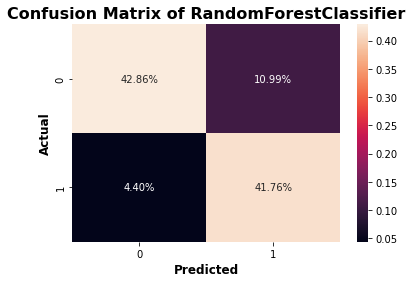

In [ ]:
#Membuat confusion matrix
gbc = RandomForestClassifier
gbc.fit(X_train,y_train)
pred = gbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix of RandomForestClassifier', fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold', fontsize=12)